# Landsat 8-9 Land Surface Temperature and QA Masking

In [1]:
import os 
import yaml
from munch import munchify

# define repo name and get root working directory
repo = 'uhi'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\uhi\\cfg'

### Retrieve Landsat 8-9 Thermal Imagery via Sentinel-Hub Process API

In [2]:
# load cfg file using yaml parser
with open( os.path.join( cfg_path, 'l8-process-lst.yml' ), 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [3]:
# create instance of shclient class
from processapi import Client
client = Client( config, base_url = 'https://services-uswest2.sentinel-hub.com' )

In [4]:
# create aoi bounding box 
coords = -2.9, 51.2, -2.5, 51.5
bbox = client.getBoundingBox( coords )
resolution = 30

In [5]:
# arbitrary timeframe
from datetime import datetime
timeframe = { 'start' : datetime( 2021, 8, 1, 0, 0, 0 ), 
                'end' : datetime( 2021, 8, 30, 23, 59, 59 ) }

In [6]:
# get time series via process api
response = client.getTimeSeries ( bbox, timeframe, resolution=resolution )
response._df[ 'lst.tif' ]

0    [[295.698, 295.88257, 295.85522, 295.44507, 29...
1    [[242.32562, 242.28802, 242.18207, 241.99065, ...
2    [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
3    [[281.2842, 281.8174, 282.27884, 282.57965, 28...
4    [[290.22574, 289.77115, 290.63934, 289.34048, ...
Name: lst.tif, dtype: object

### Visualise Landsat 8-9 Thermal Images and QA Data Masks (clear and water)

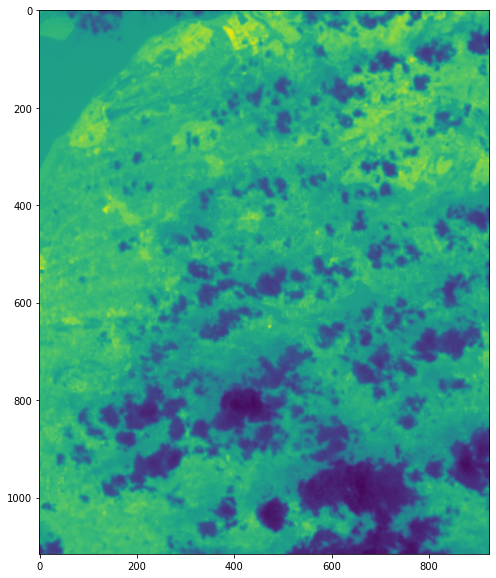

In [7]:
import matplotlib.pyplot as plt
ax = plt.figure( figsize=(10,10))

# plot thermal image
plt.imshow( response._df[ 'lst.tif' ].iloc[ 0 ] ) 

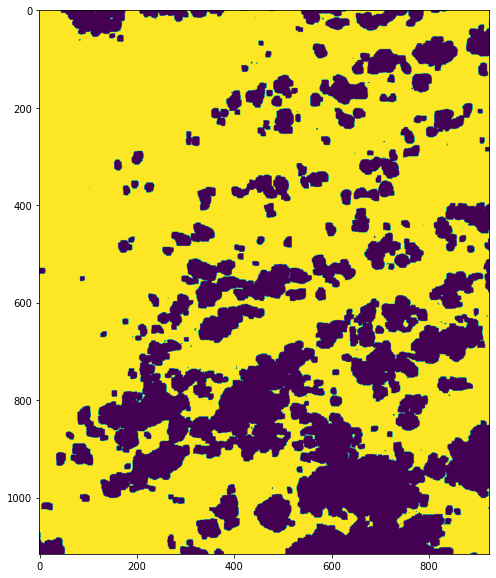

In [8]:
import matplotlib.pyplot as plt
ax = plt.figure( figsize=(10,10))

# plot clear qa band
mask = response._df[ 'data_mask.tif' ].iloc[ 0 ][ :, :, 1 ]
plt.imshow( mask ) 

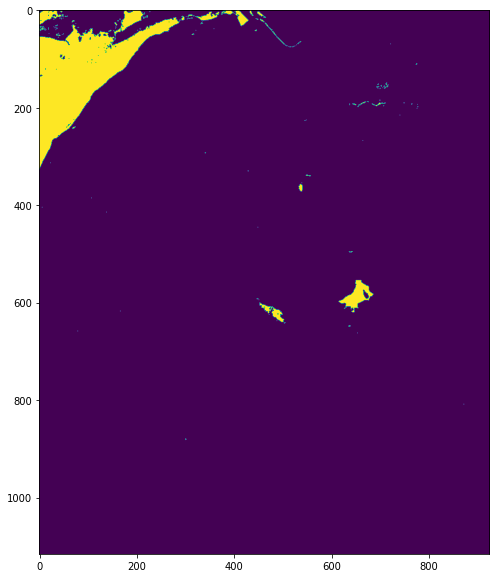

In [9]:
import matplotlib.pyplot as plt
ax = plt.figure( figsize=(10,10))

# plot water qa band
mask = response._df[ 'data_mask.tif' ].iloc[ 0 ][ :, :, 2 ]
plt.imshow( mask ) 

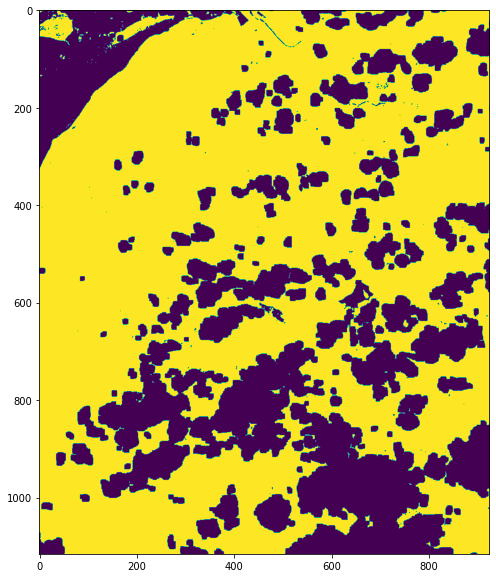

In [10]:
import matplotlib.pyplot as plt
ax = plt.figure( figsize=(10,10))

# plot combination of clear and inverted water qa bands
mask = response._df[ 'data_mask.tif' ].iloc[ 0 ][ :, :, 0 ]
plt.imshow( mask ) 

### Vectorize Clear + Non-water QA raster band to GeoDataFrame

In [11]:
import affine

# extract image geotransform
transform = affine.Affine.from_gdal( *response._transform )
transform

Affine(30.0, 0.0, 506986.74918956374,
       0.0, -30.0, 5705547.68212401)

In [ ]:
import rasterio.features
import geopandas as gpd
from shapely.geometry import shape

# convert binary qa mask into georeferenced polygons
shapes = rasterio.features.shapes( mask.astype(int), mask=mask, transform=transform)
values = []; geometry = []

# build geodataframe with output
for feature, value in shapes:
    values.append(value)
    geometry.append(shape(feature))

# create geodataframe
polygons = gpd.GeoDataFrame(
    {'value': value, 'geometry': geometry }, crs="EPSG:{}".format( response._bbox.crs.value )
)

# add further attributes and apply size threshold
polygons[ 'area' ] = polygons[ 'geometry' ].area
polygons[ 'perimeter' ] = polygons[ 'geometry' ].length

polygons = polygons.sort_values( 'area', ascending=False )
polygons = polygons[ polygons[ 'area'] > 100 * 100 ]
polygons

### Visualise QA Mask as a Collection of Georeferenced Polygons superimposed on OSM map

In [13]:
import folium

def plotMap( obj, color='orange' ):
    
    xmin, ymin, xmax, ymax = obj.geometry.total_bounds
    xc = xmin + ( ( xmax - xmin ) / 2 )
    yc = ymin + ( ( ymax - ymin ) / 2 )
    
    m = folium.Map(location=[ yc, xc ], zoom_start=10, tiles='CartoDB positron')

    for _, r in obj.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'color' : 'black', 'weight' : 1.0, 'fillColor': color} )
        geo_j.add_to(m)
    
    return m

In [14]:
plotMap( polygons.to_crs( 4326 ) )

### Compute 2021 Time Series of LST Statistics for Clear + Non-Water Georeferenced Polygons

In [34]:
# load cfg file using yaml parser
with open( os.path.join( cfg_path, 'l8-statistical-lst.yml' ), 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\uhi\\cfg'

In [30]:
# create instance of shclient class
from statisticalapi import Client
client = Client( config, base_url = 'https://services-uswest2.sentinel-hub.com'  )

In [31]:
import calendar
import pandas as pd
from datetime import datetime

def getStatistics( year ):

    stats = list()
    for month in range( 1 ):
        
        # define one month timeframe
        _, last_day = calendar.monthrange( year, month + 1 )

        timeframe = { 'start' : datetime( year, month + 1, 1, 0, 0, 0 ), 
                        'end' : datetime( year, month + 1, last_day, 23, 59, 59 ) }

        # submit request and add to list
        response = client.getStatistics( [ timeframe ], resolution=60, polygons=polygons, interval='P1D' )
        stats.extend( response._dfs )
        
    return pd.concat( [ x for x in stats if not x.empty ] )

In [32]:
stats = getStatistics( 2021 )
stats

,id,interval_from,interval_to,stats_lst_min,stats_lst_max,stats_lst_mean,stats_lst_stDev,stats_lst_sampleCount,stats_lst_noDataCount,stats_lst_percentiles_33.0,stats_lst_percentiles_50.0,stats_lst_percentiles_75.0,stats_lst_percentiles_90.0
0,geom_0,2021-01-03,2021-01-04,270.848999,276.440887,274.382975,1.026353,257796,256514,274.167877,274.523376,275.036072,275.552185
1,geom_0,2021-01-10,2021-01-11,271.385620,279.903320,274.086553,0.804846,257796,181546,273.689362,274.000397,274.550720,275.138611
2,geom_0,2021-01-19,2021-01-20,271.778687,278.245605,275.672450,1.384279,257796,257090,275.237732,275.661560,276.731415,277.524384
0,geom_1,2021-01-03,2021-01-04,271.040405,272.882721,271.754354,0.618877,8160,8127,271.327515,271.412964,272.069214,272.800690
1,geom_1,2021-01-10,2021-01-11,268.555511,274.902771,272.848284,0.682999,8160,5907,272.626373,272.947662,273.320221,273.631256
2,geom_1,2021-01-19,2021-01-20,272.058960,275.866638,274.263120,0.966507,8160,8117,273.699615,274.202087,275.056580,275.459900
0,geom_2,2021-01-10,2021-01-11,273.788483,277.114227,275.538516,0.528883,1260,893,275.319763,275.528259,275.832458,276.191345
0,geom_3,2021-01-10,2021-01-11,274.102936,277.435516,276.435519,0.612951,2176,1875,276.577606,276.717743,276.803192,276.895477
0,geom_6,2021-01-10,2021-01-11,274.290955,275.412048,274.796814,0.302719,54,20,274.619080,274.830994,275.008728,275.271912
1,geom_6,2021-01-19,2021-01-20,271.976929,271.976929,271.976929,0.000000,54,53,271.976929,271.976929,271.976929,271.976929


In [26]:
stats[ 'interval_from' ] = pd.to_datetime(stats[ 'interval_from' ])
stats[ 'interval_to' ] = pd.to_datetime(stats[ 'interval_to' ] )

stats[ 'stats_lst_dataCount' ] = stats[ 'stats_lst_sampleCount' ] - stats[ 'stats_lst_noDataCount' ]
stats

,id,interval_from,interval_to,stats_lst_min,stats_lst_max,stats_lst_mean,stats_lst_stDev,stats_lst_sampleCount,stats_lst_noDataCount,stats_lst_percentiles_33.0,stats_lst_percentiles_50.0,stats_lst_percentiles_75.0,stats_lst_percentiles_90.0,stats_lst_dataCount
0,geom_0,2021-01-03,2021-01-04,270.848999,276.440887,274.382975,1.026353,257796,256514,274.167877,274.523376,275.036072,275.552185,1282
1,geom_0,2021-01-10,2021-01-11,271.385620,279.903320,274.086553,0.804846,257796,181546,273.689362,274.000397,274.550720,275.138611,76250
2,geom_0,2021-01-19,2021-01-20,271.778687,278.245605,275.672450,1.384279,257796,257090,275.237732,275.661560,276.731415,277.524384,706
0,geom_1,2021-01-03,2021-01-04,271.040405,272.882721,271.754354,0.618877,8160,8127,271.327515,271.412964,272.069214,272.800690,33
1,geom_1,2021-01-10,2021-01-11,268.555511,274.902771,272.848284,0.682999,8160,5907,272.626373,272.947662,273.320221,273.631256,2253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,geom_34,2021-12-04,2021-12-05,279.821289,280.002441,279.896484,0.057601,6,0,279.872559,279.879395,279.934082,280.002441,6
0,geom_36,2021-12-04,2021-12-05,281.010773,281.137238,281.109039,0.038736,8,0,281.116730,281.126984,281.137238,281.137238,8
0,geom_37,2021-12-04,2021-12-05,279.223145,279.476074,279.354167,0.088706,6,0,279.373535,279.380371,279.417969,279.476074,6
1,geom_37,2021-12-12,2021-12-13,283.594788,284.339905,283.920064,0.318278,6,0,283.635803,284.076721,284.268127,284.339905,6


In [27]:
sum_stats = stats.groupby( 'interval_from' ).sum()
sum_stats = sum_stats [ [ 'stats_lst_sampleCount', 'stats_lst_dataCount' ] ]

sum_stats

,stats_lst_sampleCount,stats_lst_dataCount
interval_from,,
2021-01-03,265956,1315
2021-01-10,269803,79426
2021-01-19,266025,753
2021-02-27,270479,131821
2021-03-08,266306,19425
2021-03-15,259056,23269
2021-03-24,257796,87
2021-04-16,266370,54571
2021-05-09,1281,25


### Compute LST Mean weighted by Sample Count for all available dates 

In [28]:
records = []
for index in sum_stats.index:
    
    dataCount = sum_stats.loc[ index ][ 'stats_lst_dataCount' ]
    sampleCount = sum_stats.loc[ index ][ 'stats_lst_sampleCount' ]
    
    mean = 0.0; stdev = 0.0
    
    group = stats [ stats[ 'interval_from' ] == index ]
    for row in group.itertuples():     

        weight  = ( row.stats_lst_dataCount / dataCount )
        
        mean += row.stats_lst_mean * weight
        stdev += row.stats_lst_stDev * weight
    
    records.append( { 'date' : index , 
                      'mean' : mean,  
                      'stdev' : stdev, 
                      'dataCount' : dataCount, 
                      'percentCount' : ( dataCount / sampleCount ) * 100 } )

lst = pd.DataFrame( records )
lst

,date,mean,stdev,dataCount,percentCount
0,2021-01-03,274.317009,1.016128,1315,0.494443
1,2021-01-10,274.069282,0.797515,79426,29.438516
2,2021-01-19,275.580610,1.353526,753,0.283056
3,2021-02-27,284.453884,1.322432,131821,48.736131
4,2021-03-08,279.999428,2.001807,19425,7.294240
5,2021-03-15,283.972379,2.907610,23269,8.982228
6,2021-03-24,278.289281,1.074445,87,0.033748
7,2021-04-16,287.836602,2.869447,54571,20.486917
8,2021-05-09,282.217334,0.096855,25,1.951600
9,2021-05-11,291.291820,3.800956,18935,7.113126
